In [27]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from transformers import AutoTokenizer

1. 라벨 별 데이터 분포 확인 ✓
2. 전체 문장 길이 확인 ✓
3. entity type 별 데이터 분포 ✓
4. 라벨 별 문장 길이 확인
5. 단어 빈도 수 분석
6. tokenizing 결과에서 unknown token 확인

In [55]:
train_path = '../dataset/train/train.csv'
test_path = '../dataset/test/test_data.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
MODEL_NAME = 'klue/bert-base'
tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME)

## 라벨 별 문장 길이 분포 확인

In [22]:
def check_sentence_dist(data):
    label_sen_len = defaultdict(list)
    for i in tqdm(range(len(data))):
        label_sen_len[data.loc[i]['label']].append(len(data.loc[i]['sentence']))
    
    fig = plt.figure(figsize=(35, 17))
    for idx, (label, sentences) in enumerate(label_sen_len.items()):
        ax = fig.add_subplot(5, 6, idx+1)
        ax.set_title(label)
        ax.hist(sorted(sentences))
        
    plt.show()

100%|██████████| 32470/32470 [00:07<00:00, 4213.08it/s]


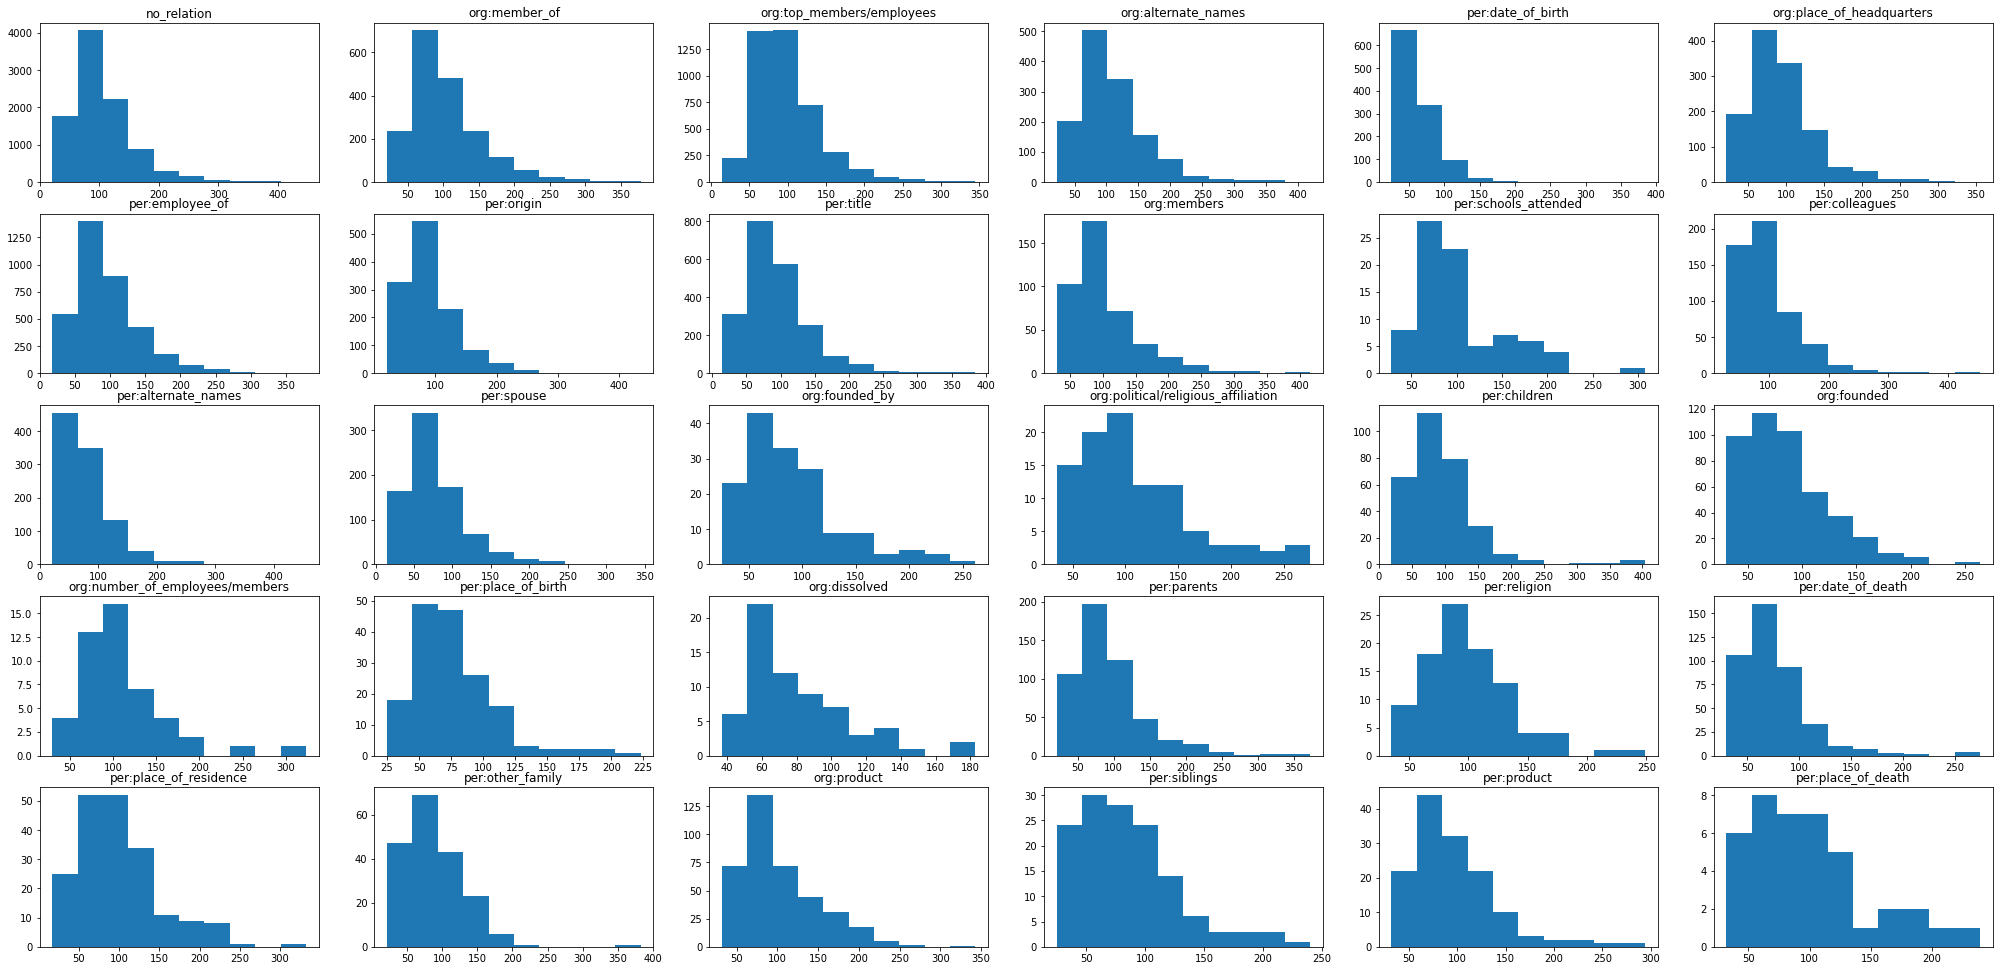

In [23]:
check_sentence_dist(train_data)

100%|██████████| 7765/7765 [00:01<00:00, 4063.05it/s]


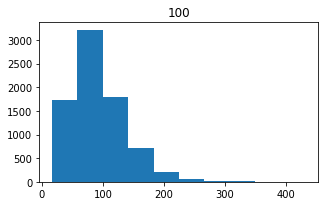

In [24]:
check_sentence_dist(test_data)

## 단어 빈도 수 분석

In [30]:
# tokenizing
def preprocessing_dataset(dataset):
    subject_entity = []
    object_entity = []
    
    for i,j in zip(dataset['subject_entity'], dataset['object_entity']):
        i = i[1:-1].split(',')[0].split(':')[1]
        j = j[1:-1].split(',')[0].split(':')[1]
        subject_entity.append(i)
        object_entity.append(j)
        
    out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],'subject_entity':subject_entity,'object_entity':object_entity,'label':dataset['label']})
    return out_dataset


def load_data(dataset_dir):
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)
    return dataset


def tokenized_dataset(dataset, tokenizer=tokenizer):
    concat_entity = []
    
    for e01, e02 in zip(dataset['subject_entity'], dataset['object_entity']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
        
    tokenized_sentences = tokenizer(
        concat_entity,
        list(dataset['sentence']),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
        )
    return tokenized_sentences

In [31]:
tokenized_train_data = tokenized_dataset(load_data(train_path))
tokenized_test_data = tokenized_dataset(load_data(test_path))

In [142]:
from collections import defaultdict

def words_frequency(data):
    dic = defaultdict(int)
    ids = data['input_ids'].reshape(-1).tolist()
    for i in ids:
        dic[i] += 1
        
    dic = dict(sorted(dic.items(), key=lambda x:x[1], reverse=True))
    top_keys = list(dic.keys())[:2000]  # 출력할 단어 수 조정
    freq_dic = defaultdict()
    for i in top_keys:
        word = tokenizer.decode(i)
        if '#' not in word:  # #이 붙어있으면 거의 조사이므로 제외
            freq_dic[word] = dic[i]
        
    return freq_dic
    

In [143]:
words_frequency(tokenized_train_data)

defaultdict(None,
            {'[PAD]': 5729275,
             "'": 135879,
             '[SEP]': 97410,
             ',': 37642,
             '.': 36487,
             '[CLS]': 32470,
             '(': 19339,
             ')': 19318,
             '[UNK]': 6953,
             '있': 6767,
             '1': 5774,
             '"': 5465,
             '2': 5248,
             '등': 4850,
             '이': 4254,
             '3': 4169,
             '그': 3412,
             '4': 3347,
             '는': 3262,
             '-': 3244,
             '~': 3187,
             '·': 2964,
             '5': 2820,
             '한국': 2676,
             '은': 2649,
             '것': 2608,
             '제': 2590,
             '10': 2425,
             '하': 2393,
             '대한민국': 2348,
             '되': 2247,
             '6': 2237,
             '‘': 2190,
             '’': 2189,
             '8': 2186,
             '7': 2133,
             '고': 2049,
             '전': 1992,
             '“': 1988,
             '

In [90]:
words_frequency(tokenized_test_data)

defaultdict(None,
            {'있': 2265,
             '"': 1688,
             '”': 1442,
             '“': 1441,
             '등': 1334,
             '것': 1166,
             '이': 1057,
             '[UNK]': 1051,
             '1': 1038,
             '2': 963,
             '고': 914,
             '’': 811,
             '‘': 806,
             '3': 806,
             '그': 793,
             '수': 719,
             '·': 695,
             '말': 630,
             '하': 610,
             '4': 610,
             '5': 589,
             '위해': 547,
             '지난': 525,
             '되': 515,
             '한국': 510,
             '밝혔': 494,
             '및': 490,
             '한': 489,
             '제': 468,
             '-': 452,
             '씨': 452,
             '지역': 441,
             '함께': 426,
             '중': 425,
             '%': 419,
             '6': 416,
             '정부': 411,
             '10': 403,
             '이라': 401,
             '대한': 397,
             '며': 392,
             '는'

## tokenizing 결과에서 unknown token 확인

In [133]:
# [UNK] token id => 1
def unk(data, df):
    unk_sen = []
    tokenized_sentences = data['input_ids'].tolist()
    for t in tokenized_sentences:
        if 1 in t:
            unk_sen.append(tokenized_sentences.index(t))
            
    origin_sen = df.loc[unk_sen]['sentence']
    decoded_sen = [tokenizer.decode(tokenized_sentences[i]).split('[SEP]')[-2].lstrip().replace('[PAD]', '') for i in unk_sen]
    
    return pd.DataFrame({
        'origin_sentence': origin_sen,
        'decoded_sentence': decoded_sen
    })

In [134]:
unk(tokenized_train_data, train_data)

,origin_sentence,decoded_sentence
7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","박용오 ( 朴 [UNK] [UNK], 1937년 4월 29일 ( 음력 3월 19일 ..."
21,2010년에는 아시아 가수 최초로 마이클 잭슨의 곡을 리메이크하였는데 당시 마이클 ...,2010년에는 아시아 가수 최초로 마이클 잭슨의 곡을 리메이크하였는데 당시 마이클 ...
52,"(KIA 내야수 그, 투수 이동현, 외야수 김경언 ↔ 한화 투수 안영명, 박성호, ...","( KIA 내야수 그, 투수 이동현, 외야수 김경언 [UNK] 한화 투수 안영명, ..."
83,진도군은 진도개를 보기 위해 찾아온 관람객들에게 더욱 흥미롭고 즐거움을 선사하기 위...,진도군은 진도개를 보기 위해 찾아온 관람객들에게 더욱 흥미롭고 즐거움을 선사하기 위...
91,"백한성(白漢成, 水原鶴人, 1899년 6월 15일 조선 충청도 공주 출생 ~ 197...","백한성 ( 白 漢 成, 水 原 [UNK] 人, 1899년 6월 15일 조선 충청도 ..."
...,...,...
32441,"윤종필 자유한국당 의원은 이날 ""현재 청소년들 휴대폰 과의존 문제가 심각하다""라며 ...","윤종필 자유한국당 의원은 이날 "" 현재 청소년들 휴대폰 과의존 문제가 심각하다 "" ..."
32442,"해병대의 원산 상륙으로 놀란 이후, 중화인민공화국 주석 마오쩌둥은 전보를 통해 중국...","해병대의 원산 상륙으로 놀란 이후, 중화인민공화국 주석 마오쩌둥은 전보를 통해 중국..."
32446,"8월 2일에는 이정모 서울시립과학관 관장 ‘알바트로스’를 주제로, 9일에는 금정연 ...","8월 2일에는 이정모 서울시립과학관 관장 ‘ 알바트로스 ’ 를 주제로, 9일에는 금..."
32449,"이때 만주 지역에는 크고작은 독립군이 조직되었고, 동만주지방의 홍범도가 이끄는 대한...","이때 만주 지역에는 크고작은 독립군이 조직되었고, 동만주지방의 홍범도가 이끄는 대한..."


In [135]:
unk(tokenized_test_data, test_data)

,origin_sentence,decoded_sentence
16,"강명구(姜明求, 1917년~2000년)는 대한민국의 건축가이다.","강명구 ( [UNK] 明 求, 1917년 ~ 2000년 ) 는 대한민국의 건축가이다."
32,일찍이 이천(利川)의 율정(栗亭) 이관의(李寬義)의 문하에서 수학하였다.,일찍이 이천 ( 利 川 ) 의 율정 ( [UNK] [UNK] ) 이관의 ( [UNK...
51,잉글랜드와 로마 사이의 친밀감은 1526년 코냑 동맹의 공식화에서 볼 수 있다.,잉글랜드와 로마 사이의 친밀감은 1526년 [UNK] 동맹의 공식화에서 볼 수 있다.
59,초기에는 대부분의 경우 '탈퇴'라는 표현을 사용하였지만(결성 당시부터 나카자와 졸업...,초기에는 대부분의 경우'탈퇴'라는 표현을 사용하였지만 ( 결성 당시부터 나카자와 졸...
69,"1775년(영조 51) 4월 24일 영조의 특명으로 흥록대부(興祿大夫)에 가자되고,...",1775년 ( 영조 51 ) 4월 24일 영조의 특명으로 흥록대부 ( [UNK] [...
...,...,...
7650,허소가 ‘착융은 명분을 돌아보는 사람이 아닌 반면 주문명(朱文明)은 사람을 잘 믿으...,허소가 ‘ 착융은 명분을 돌아보는 사람이 아닌 반면 주문명 ( [UNK] 文 明 )...
7687,쑨양은 지난 2012년 런던 올림픽에서 오랫동안 깨어지지 않았던 호주의 Grannt...,[UNK] 지난 2012년 런던 올림픽에서 오랫동안 깨어지지 않았던 호주의 Gran...
7739,카를로스 살제도는 프랑스 아르카숑에서 1885년 4월 6일에 샤를 무아즈 레옹 살제...,카를로스 살제도는 프랑스 [UNK] 1885년 4월 6일에 샤를 무아즈 레옹 살제도...
7742,"그 외에 참석한 사람들은 보의 얼굴, 발훈의 목스, 반복된 밈의 추종자들, 에서 온...","그 외에 참석한 사람들은 보의 얼굴, 발훈의 목스, 반복된 [UNK] 추종자들, 에..."


In [145]:
# 출력으로 분석이 힘들어서 csv로 저장해서 확인

train_words = list(words_frequency(tokenized_train_data).keys())
train_freq = list(words_frequency(tokenized_train_data).values())
test_words = list(words_frequency(tokenized_test_data).keys())
test_freq = list(words_frequency(tokenized_test_data).values())

d1, d2 = pd.DataFrame(), pd.DataFrame()
d1['words'] = train_words
d1['freq'] = train_freq
d2['words'] = test_words
d2['freq'] = test_freq

d1.to_csv('./eda/train_word_frequency.csv', encoding='utf-8-sig')
d2.to_csv('./eda/test_word_frequency.csv', encoding='utf-8-sig')
unk(tokenized_train_data, train_data).to_csv('./eda/train_unknown.csv', encoding='utf-8-sig')
unk(tokenized_test_data, test_data).to_csv('./eda/test_unknown.csv', encoding='utf-8-sig')